In [1]:
import numpy as np
import matplotlib.pyplot as plt

First we simulate JFK and Standard Rate rides with the same linear regression as in the data, but with no error. This should be extremely easy to fit with the standard EM algorithm.

In [2]:
distances = np.random.uniform(0, 60, size = 10000).reshape(10000, -1)
trip_type = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
beta_0 = 52 * trip_type
beta_1 = 2.29 * (1 - trip_type)
cost = beta_0 + distances * beta_1
cost = cost.reshape(-1)

Compare the scatter plot below to the scatter plot from our project proposal.

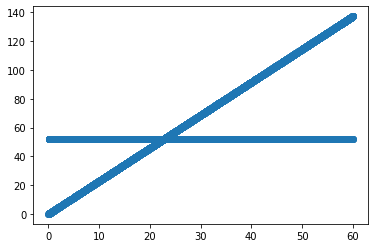

In [5]:
plt.scatter(distances, cost)

The functions below run the the mixed regression algorithms. Note that the master function is at the bottom. The improved initialization procedure from the paper still needs to be written.

In [89]:
def initialize_classic(n_features, mean = 0.0, sd = 1.0):
    betas = {}
    for i in range(2):
        betas[i] = np.random.normal(mean, sd, n_features)
    return(betas)

def initialize_optimal(X, y, delta=0.3):
    M = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[1]):
        M += y[i]**2 * np.outer(X[:,i], X[:,i])
    M /= X.shape[1]
    
    eigenvalues, eigenvectors = np.linalg.eig(M)
    sorted_eigs = sorted(zip(eigenvalues, eigenvectors), key=lambda x: x[0], reverse=True)
    v1 = sorted_eigs[0][1]
    v2 = sorted_eigs[1][1]
    
    G = []
    for i in range(int(np.ceil(2*np.pi/delta)) + 1):
        G.append(v1 * np.cos(delta*i) + v2 * np.sin(delta*i))
    
    min_loss = np.inf
    for u1 in G:
        for u2 in G:
            loss = 0
            for i in range(X.shape[1]):
                l1 = y[i] - np.dot(X[:,i], u1)
                l2 = y[i] - np.dot(X[:,i], u2)
                loss = min(l1**2, l2**2)
                if loss < min_loss:
                    min_loss = loss
                    betas = {0:u1, 1:u2}
    return betas
            
            

def run_EM_iteration(X, y, betas):
    pred0 = X.transpose().dot(betas[0])
    pred1 = X.transpose().dot(betas[1])
    err0 = np.abs(pred0 - y)
    err1 = np.abs(pred1 - y)
    lower_error = (err0 < err1)
    j0_ind = np.where(lower_error)
    j1_ind = np.where(~lower_error)
    j0 = distances[j0_ind]
    j1 = distances[j1_ind]
    
    ##Solve least squares
    ones_0 = np.ones(j0.size)
    ones_1 = np.ones(j1.size)
    X_0 = np.array([ones_0, j0.reshape(-1)])
    X_1 = np.array([ones_1, j1.reshape(-1)])
    
    try:
        beta_0 = np.linalg.inv(X_0.dot(X_0.transpose())).dot(X_0).dot(y[j0_ind])
    except:
        beta_0 = betas[0]
    
    try:
        beta_1 = np.linalg.inv(X_1.dot(X_1.transpose())).dot(X_1).dot(y[j1_ind])
    except:
        beta_1 = betas[1]
    
    betas = {0: beta_0,
             1: beta_1}
    
    iter_err_0 = np.sum((beta_0.dot(X_0) - y[j0_ind])**2)
    iter_err_1 = np.sum((beta_1.dot(X_1) - y[j1_ind])**2)
    iter_err = np.log(np.sqrt(iter_err_0 + iter_err_1))
    
    return(betas, iter_err)

def fit_mixed_regression(x, y, n_iter = 10, algo_type = 'classic'):
    n_samples = x.size
    ones = np.ones(x.size)
    X = np.array([ones, x.reshape(-1)])
    
    #initialize parameters
    if algo_type == 'classic':
        betas = initialize_classic(X.shape[0])
    else:
        betas = initialize_optimal(X, y)

    iter_errs = []
    for j in range(n_iter):
        betas, iter_err = run_EM_iteration(X, y, betas)
        iter_errs.append(iter_err)
    return(betas, iter_errs)

The fitting procedure currently returns the final beta parameters and a list of the errors at the end of each iteration. Note that changing the seed may cause errors. I think this is because the random initialization of beta parameters sometimes results in all or almost all of the data belonging to one of the latent classes, so doing matrix operations is nonsense or causes singular matrix errors. We need to come up with a solution to this. (I was unable to tell what initialization procedure they use in the paper for the standard EM algorithm. I'm not sure if my version is comparable.)

In [105]:
np.random.seed(47)
betas, iter_errs = fit_mixed_regression(distances, cost, algo_type = 'classic')
betas_opt, iter_errs_opt = fit_mixed_regression(distances, cost, algo_type = 'optimal')

We see that we recover the true coefficients almost immediately. This is what I expected to see for a case with no noise and lines that are mostly not near each other.

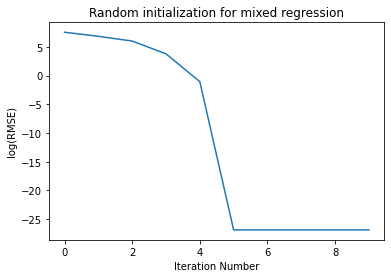

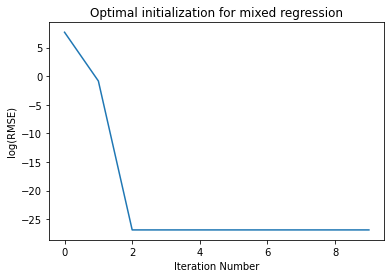

In [106]:
plt.plot(iter_errs)
plt.xlabel('Iteration Number')
plt.ylabel('log(RMSE)')
plt.title('Random initialization for mixed regression')
plt.show()

plt.plot(iter_errs_opt)
plt.xlabel('Iteration Number')
plt.ylabel('log(RMSE)')
plt.title('Optimal initialization for mixed regression')
plt.show()